In [9]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm

In [10]:
""" 
卷积朴素实现
def conv2d(input, weight, bias=None, stride=1, padding=0):
    batch_size, in_channels, in_height, in_width = input.size()
    out_channels, _, kernel_height, kernel_width = weight.size()
    out_height = int((in_height + 2 * padding - kernel_height) / stride) + 1
    out_width = int((in_width + 2 * padding - kernel_width) / stride) + 1
    padded_input = torch.nn.functional.pad(input, (padding, padding, padding, padding))
    output = torch.zeros(batch_size, out_channels, out_height, out_width)
    for b in range(batch_size):
        for c_out in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    h_start = h_out * stride
                    w_start = w_out * stride
                    h_end = h_start + kernel_height
                    w_end = w_start + kernel_width
                    input_patch = padded_input[b, :, h_start:h_end, w_start:w_end]
                    output[b, c_out, h_out, w_out] = torch.sum(input_patch * weight[c_out]) + (bias[c_out] if bias is not None else 0)
    return output
"""

def conv2d(inputs, weight, bias=None, stride=1, padding=0):
    padded_input = torch.nn.functional.pad(inputs, (padding, padding, padding, padding))
    output = torch.nn.functional.conv2d(padded_input, weight, bias=bias, stride=stride)
    return output

In [11]:
"""
max 池化朴素实现
def max_pool2d(input, kernel_size, stride=None, padding=0):
    batch_size, channels, height, width = input.size()
    output_height = int((height + 2 * padding - kernel_size) / stride) + 1
    output_width = int((width + 2 * padding - kernel_size) / stride) + 1
    output = torch.zeros(batch_size, channels, output_height, output_width)
    for b in range(batch_size):
        for c in range(channels):
            for i in range(output_height):
                for j in range(output_width):
                    avg_value = torch.max(
                        input[b, c, i * stride:i * stride + kernel_size, j * stride:j * stride + kernel_size]
                    )
                    output[b, c, i, j] = avg_value
    return output
"""

def max_pool2d(input, kernel_size, stride=None, padding=0):
    output = torch.nn.functional.max_pool2d(input, kernel_size, stride=stride, padding=padding)
    return output

In [12]:
def dropout(X, p):
    """dropout"""
    return X * torch.empty_like(X.bernoulli_(1 - p) / (1 - p))
#     return torch.nn.functional.dropout(X, p=p, training=True)

In [13]:
def relu(x):
    return torch.max(torch.zeros_like(x), x)

In [14]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [15]:
class VggNet:
    def __init__(self, conv_arch):
        self._init_params(conv_arch)
        
    def _init_params(self, conv_arch):
        """初始化参数"""
        def normal(shape):
            return torch.nn.init.xavier_uniform_(torch.empty(shape))
        def vgg_block(num_convs, in_channels, out_channels):
            params = []
            for _ in range(num_convs):
                """输出通道 * 输入通道 * 卷积核边长 * 卷积核边长"""
                params.append([
                    normal((out_channels, in_channels, 3, 3)),
                    torch.zeros(out_channels, device=device)
                ])
                in_channels = out_channels
            return params
        conv_blks = []
        in_channels = 1
        for (num_convs, out_channels) in conv_arch:
            conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
            in_channels = out_channels
        W_h1h2 = normal((out_channels * 7 * 7, 4096)); b_h1h2 = torch.zeros(4096, device=device);
        W_h2h3 = normal((4096, 4096)); b_h2h3 = torch.zeros(4096, device=device);
        W_h3y = normal((4096, 10)); b_h3y = torch.zeros(10, device=device);
        linears = [W_h1h2, b_h1h2, W_h2h3, b_h2h3, W_h3y, b_h3y]
        params = [conv_blks, linears]
        self.flt_params = []
        for vgg_blk in conv_blks:
            for W, b in vgg_blk:
                self.flt_params.append(W)
                self.flt_params.append(b)
        for param in linears:
            self.flt_params.append(param)
        for param in self.flt_params:
            param.requires_grad_(True)
        self.params = params
    
    def _forward(self, X):
        """推理函数"""
        conv_blks, [W_h1h2, b_h1h2, W_h2h3, b_h2h3, W_h3y, b_h3y] = self.params
        for vgg_blk in conv_blks:
            for W, b in vgg_blk:
                X = relu(conv2d(X, W, b, stride=1, padding=1))
            X = max_pool2d(X, kernel_size=2, stride=2, padding=0)
        H1 = X.reshape(X.size(0), -1) # 展平
        H2 = dropout(relu(H1 @ W_h1h2 + b_h1h2), 0.5)
        H3 = dropout(relu(H2 @ W_h2h3 + b_h2h3), 0.5)
        Y = sigmoid(H3 @ W_h3y + b_h3y)
        return Y
    
    def update(self, X, y, lr):
        """更新函数"""
        y_hat = self._forward(X)
        l = self._loss(y_hat, y)
        l.mean().backward()
        self.grad_clipping(1)
        """sgd"""
        with torch.no_grad():
            for param in self.flt_params:
                param -= lr * param.grad / X.shape[0]
                param.grad.zero_()
        return l
                
    def _loss(self, y_hat, y):
        """交叉熵损失"""
        return - torch.log(y_hat[range(len(y_hat)), y])
                
    def __call__(self, X):
        return self._forward(X)
    
    def grad_clipping(self, theta):
        norm = torch.sqrt(sum([torch.sum(p ** 2) for p in self.flt_params]))
        if norm > theta:
            for param in self.flt_params:
                param.grad[:] *= theta / norm

In [18]:
device = 'cpu'
# conv_arch = ((1, 64), (1, 64), (2, 64), (2, 64), (2, 64))
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = VggNet(conv_arch)
X = torch.randn(1, 1, 224, 224); y = torch.tensor([1, 2, 3, 4])
for epoch in range(3):
    l = net.update(X, y, lr=1)
    print('epoch %d loss %f' % (epoch + 1, l.mean()))

epoch 1 loss 0.696255
epoch 2 loss 0.697100
epoch 3 loss 0.684306


In [24]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = VggNet(small_conv_arch)

lr, num_epochs, batch_size = 0.1, 1, 4
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [25]:
for epoch in range(num_epochs):
    metrics = [0, 0]
    i = 0
    for X, y in train_iter:
        l = net.update(X, y, lr=lr)
        metrics[0] += l.sum(); metrics[1] += y.numel()
        i += 1
        print('i %d loss %f' % (i + 1, metrics[0] / metrics[1]))
        if i > 10:
            break
    print('epoch %d loss %f' % (epoch + 1, metrics[0] / metrics[1]))

i 2 loss 0.697039
i 3 loss 0.695934
i 4 loss 0.695515
i 5 loss 0.695254
i 6 loss 0.694658
i 7 loss 0.694659
i 8 loss 0.694569
i 9 loss 0.694835
i 10 loss 0.694832
i 11 loss 0.694741
i 12 loss 0.694543
epoch 1 loss 0.694543


array([<AxesSubplot:title={'center':'ankle boot\nshirt'}>,
       <AxesSubplot:title={'center':'pullover\nankle boot'}>,
       <AxesSubplot:title={'center':'trouser\nankle boot'}>,
       <AxesSubplot:title={'center':'trouser\nshirt'}>], dtype=object)

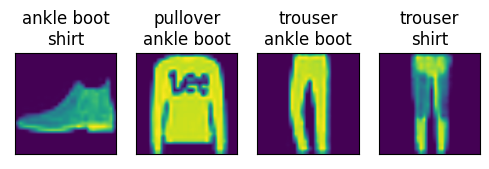

In [26]:
for X, y in test_iter:
    break
n = 4
trues = d2l.get_fashion_mnist_labels(y)
preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
d2l.show_images(
    X[0:n, 0, :, :], 1, n, titles=titles[0:n])